# Replacing Portfolio Organization Name YML with Airtable
* GTFS Digest still uses the YML
* Open_data products

In [1]:
import pandas as pd
from calitp_data_analysis.sql import get_engine
from calitp_data_analysis.tables import tbls
from segment_speed_utils import helpers
from shared_utils import catalog_utils, gtfs_utils_v2, schedule_rt_utils
from update_vars import GTFS_DATA_DICT, SCHED_GCS

db_engine = get_engine()

In [2]:
import datetime

import geopandas as gpd
import google.auth
import numpy as np
import pandas as pd
import yaml
from calitp_data_analysis import geography_utils, utils
from segment_speed_utils import helpers
from shared_utils import (
    dask_utils,
    portfolio_utils,
    publish_utils,
    rt_dates,
    shared_data,
)

credentials, project = google.auth.default()
import gcsfs

fs = gcsfs.GCSFileSystem()

In [3]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [4]:
analysis_date = "2025-06-11"

In [5]:
date = "2025-06-11"

In [6]:
SHN_HWY_BUFFER_FEET = 50

## `open_data/create_routes_data`

In [7]:
def create_routes_file_for_export(date: str) -> gpd.GeoDataFrame:
    """
    Create a shapes (with associated route info) file for export.
    This allows users to plot the various shapes,
    transit path options, and select between variations for
    a given route.
    """
    # Read in local parquets
    trips = helpers.import_scheduled_trips(
        date,
        columns=[
            "name",
            "gtfs_dataset_key",
            "route_id",
            "route_type",
            "shape_id",
            "shape_array_key",
            "route_long_name",
            "route_short_name",
            "route_desc",
        ],
        get_pandas=True,
    ).dropna(subset="shape_array_key")

    shapes = helpers.import_scheduled_shapes(
        date,
        columns=["shape_array_key", "n_trips", "geometry"],
        get_pandas=True,
        crs=geography_utils.WGS84,
    ).dropna(subset="shape_array_key")

    df = (
        pd.merge(shapes, trips, on="shape_array_key", how="inner")
        .drop_duplicates(subset="shape_array_key")
        .drop(columns="shape_array_key")
    )

    drop_cols = ["route_short_name", "route_long_name", "route_desc"]
    route_shape_cols = ["schedule_gtfs_dataset_key", "route_id", "shape_id"]

    routes_assembled = (
        portfolio_utils.add_route_name(df)
        .drop(columns=drop_cols)
        .sort_values(route_shape_cols)
        .drop_duplicates(subset=route_shape_cols)
        .reset_index(drop=True)
    )

    routes_assembled = routes_assembled.pipe(remove_erroneous_shapes)

    routes_assembled = routes_assembled.assign(
        route_length_feet=routes_assembled.geometry.to_crs(
            geography_utils.CA_NAD83Albers_ft
        ).length
    )
    return routes_assembled

In [8]:
def remove_erroneous_shapes(
    shapes_with_route_info: gpd.GeoDataFrame,
) -> gpd.GeoDataFrame:
    """
    Check if line is simple for Amtrak. If it is, keep.
    If it's not simple (line crosses itself), drop.

    In Jun 2023, some Amtrak shapes appeared to be funky,
    but in prior months, it's been ok.
    Checking for length is fairly time-consuming.
    """
    amtrak = "Amtrak Schedule"

    possible_error = shapes_with_route_info[shapes_with_route_info.name == amtrak]
    ok = shapes_with_route_info[shapes_with_route_info.name != amtrak]

    # Check if the line crosses itself
    ok_amtrak = (
        possible_error.assign(simple=possible_error.geometry.is_simple)
        .query("simple == True")
        .drop(columns="simple")
    )

    ok_shapes = pd.concat([ok, ok_amtrak], axis=0).reset_index(drop=True)

    return ok_shapes

In [9]:
routes = create_routes_file_for_export(analysis_date)

In [10]:
def patch_previous_dates(
    current_routes: gpd.GeoDataFrame,
    current_date: str,
    published_operators_yaml: str = "../gtfs_funnel/published_operators.yml",
) -> gpd.GeoDataFrame:
    """
    Compare to the yaml for what operators we want, and
    patch in previous dates for the 10 or so operators
    that do not have data for this current date.
    """
    # Read in the published operators file
    with open(published_operators_yaml) as f:
        published_operators_dict = yaml.safe_load(f)

    # Convert the published operators file into a dict mapping dates to an iterable of operators
    patch_operators_dict = {
        str(date): operator_list
        for date, operator_list in published_operators_dict.items()
        if str(date)
        != current_date  # Exclude the current (analysis) date, since that does not need to be patched
    }

    partial_dfs = []

    # For each date and corresponding iterable of operators, get the data from the last time they appeared
    for one_date, operator_list in patch_operators_dict.items():
        df_to_add = publish_utils.subset_table_from_previous_date(
            gcs_bucket=TRAFFIC_OPS_GCS,
            filename=f"ca_transit_routes",
            operator_and_dates_dict=patch_operators_dict,
            date=one_date,
            crosswalk_col="schedule_gtfs_dataset_key",
            data_type="gdf",
        )

        partial_dfs.append(df_to_add)

    patch_routes = pd.concat(partial_dfs, axis=0, ignore_index=True)

    # Concat the current data to the "backfill" data
    published_routes = pd.concat(
        [current_routes, patch_routes], axis=0, ignore_index=True
    )
    # Drop Duplicates
    published_routes = published_routes.drop_duplicates().reset_index(drop=True)
    return published_routes

In [11]:
TRAFFIC_OPS_GCS = f"{GTFS_DATA_DICT.gcs_paths.GCS}traffic_ops/"

In [12]:
published_routes = patch_previous_dates(
    routes,
    analysis_date,
)

In [13]:
len(published_routes)

16008

## Adding SHN -> % of Transit Route on SHS exceeds 100%...Why?

In [14]:
def add_shn_information(gdf: gpd.GeoDataFrame, buffer_amt: int) -> pd.DataFrame:
    """
    Prepare the gdf to join with the existing transit_routes
    dataframe that is published on the Open Data Portal
    """
    # Retain only the longest shape for each name-route_id combo
    # so finding the intersection with SHN won't take as long
    # Overlay
    intersecting = routes_shn_intersection(gdf, buffer_amt)

    # Group the dataframe so that one route only has one
    # row instead of multiple rows after finding its
    # intersection with any SHN routes.
    # print(intersecting.columns)
    agg1 = group_route_district(intersecting)

    # Merge the dataframe with all the SHS info with the original
    # gdf so we can get the original transit route geometries &
    # any routes that don't intersect with the state highway routes.
    m1 = pd.merge(gdf, agg1, on=["route_id", "name", "shape_id"], how="left")

    # Add yes/no column to signify if a transit route intersects
    # with a SHN route
    m1.pct_route_on_hwy_across_districts = m1.pct_route_on_hwy_across_districts.fillna(
        0
    )
    m1["on_shs"] = np.where(m1["pct_route_on_hwy_across_districts"] == 0, 0, 1)

    # Clean up rows that are tagged as "on_shs==N" but still have values
    # that appear.
    m1.loc[
        (m1["on_shs"] == "N") & (m1["shn_districts"] != "0"),
        ["shn_districts", "shn_route"],
    ] = np.nan

    return m1

In [15]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/shared_data/"

In [16]:
HWY_FILE = (
    f"{GCS_FILE_PATH}shn_buffered_{50}_ft_shn_dissolved_by_ct_district_route.parquet"
)

In [17]:
HWY_FILE
# gs://calitp-analytics-data/data-analyses/shared_data/shn_buffered_50_ft_shn_dissolved_by_ct_district_route.parquet

'gs://calitp-analytics-data/data-analyses/shared_data/shn_buffered_50_ft_shn_dissolved_by_ct_district_route.parquet'

In [18]:
def routes_shn_intersection(
    routes_gdf: gpd.GeoDataFrame, buffer_amount: int
) -> gpd.GeoDataFrame:
    """
    Overlay the most recent transit routes with a buffered version
    of the SHN
    """
    GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/shared_data/"

    # Read in buffered shn here or re buffer if we don't have it available.
    HWY_FILE = f"{GCS_FILE_PATH}shn_buffered_{buffer_amount}_ft_shn_dissolved_by_ct_district_route.parquet"

    if fs.exists(HWY_FILE):
        shn_routes_gdf = gpd.read_parquet(
            HWY_FILE, storage_options={"token": credentials.token}
        )
    else:
        shn_routes_gdf = shared_data.buffer_shn(buffer_amount)

    # Process the most recent transit route geographies and ensure the
    # CRS matches the SHN routes' GDF so the overlay doesn't go wonky.
    routes_gdf = routes_gdf.to_crs(shn_routes_gdf.crs)

    # Overlay transit routes with the SHN geographies.
    gdf = gpd.overlay(
        routes_gdf, shn_routes_gdf, how="intersection", keep_geom_type=True
    )

    # Calcuate the percent of the transit route that runs on a highway, round it up and
    # multiply it by 100
    gdf = gdf.assign(
        pct_route_on_hwy=(gdf.geometry.length / gdf.route_length_feet).round(3) * 100,
    )
    # Subset
    gdf2 = gdf[
        [
            "name",
            "pct_route_on_hwy",
            "route_id",
            "shape_id",  # maybe comment out later
            "district",
            "shn_route",
        ]
    ]

    # Clean up
    gdf2.district = gdf2.district.fillna(0).astype(int)

    gdf2 = gdf2.rename(
        columns={
            "pct_route_on_hwy": "pct_route_on_hwy_across_districts",
            "district": "shn_districts",
        }
    )

    # Delete duplicates
    gdf2 = gdf2.drop_duplicates().reset_index()
    gdf3 = gdf2.drop_duplicates(
        subset=["name", "route_id", "shape_id", "shn_route", "shn_districts"]
    )
    return gdf3

In [19]:
def group_route_district(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate by adding all the districts and SHN to a single row, rather than
    multiple and sum up the total % of SHN a transit route intersects with.

    df: the dataframe you want to aggregate
    pct_route_on_hwy_agg: whether you want to find the max, min, sum, etc on the column
    "pct_route_on_hwy_across_districts"
    """

    agg1 = (
        df.groupby(
            ["name", "route_id", "shape_id"],  # maybe comment out later
            as_index=False,
        )[["shn_route", "shn_districts", "pct_route_on_hwy_across_districts"]]
        .agg(
            {
                "shn_route": lambda x: ", ".join(set(x.astype(str))),
                "shn_districts": lambda x: ", ".join(set(x.astype(str))),
                "pct_route_on_hwy_across_districts": "sum",
            }
        )
        .reset_index(drop=True)
    )

    # Clean up
    agg1.pct_route_on_hwy_across_districts = (
        agg1.pct_route_on_hwy_across_districts.astype(float).round(2)
    )

    return agg1

In [20]:
shn_df1 = routes_shn_intersection(published_routes, SHN_HWY_BUFFER_FEET)

/tmp/ipykernel_2227/3507653536.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf2.district = gdf2.district.fillna(0).astype(int)


In [21]:
len(shn_df1)

21709

In [22]:
len(published_routes)

16008

In [23]:
shn_df1.pct_route_on_hwy_across_districts.describe()

count   21472.00
mean        6.41
std        15.67
min         0.00
25%         0.10
50%         0.30
75%         2.30
max        99.20
Name: pct_route_on_hwy_across_districts, dtype: float64

In [24]:
len(shn_df1)

21709

In [25]:
len(published_routes)

16008

### Check some examples
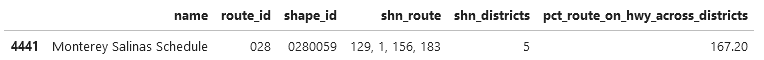

In [ ]:
monterey_ex = shn_df1.loc[
    (shn_df1.name == "Monterey Salinas Schedule")
    & (shn_df1.route_id == "028")
    & (shn_df1.shape_id == "0280059")
]

In [ ]:
monterey_ex

In [ ]:
shn_df2 = group_route_district(shn_df1)

In [ ]:
shn_df2.pct_route_on_hwy_across_districts.describe()

In [ ]:
shn_df2.loc[shn_df2.pct_route_on_hwy_across_districts > 100]

In [ ]:
stc_ex = shn_df1.loc[
    (shn_df1.name == "Santa Cruz Schedule")
    & (shn_df1.route_id == "17")
    & (shn_df1.shape_id == "shp-17-13")
]

In [ ]:
stc_ex.sort_values(by=["shn_districts"])

In [ ]:
shn_df2.loc[
    (shn_df2.name == "Santa Cruz Schedule")
    & (shn_df2.route_id == "17")
    & (shn_df2.shape_id == "shp-17-13")
]

In [ ]:
shn_routes_gdf = gpd.read_parquet(
    HWY_FILE, storage_options={"token": credentials.token}
)

In [ ]:
shn_routes_gdf_filtered = shn_routes_gdf.loc[
    shn_routes_gdf.shn_route.isin(["880", "1", "35", "280", "9", "17", "85", "87"])
]

In [ ]:
shn_routes_gdf_filtered = shn_routes_gdf_filtered.loc[
    shn_routes_gdf_filtered.district.isin([4, 5])
]

In [ ]:
shn_routes_gdf_filtered["district_str"] = shn_routes_gdf_filtered.district.astype(str)

In [ ]:
stc_og_gdf = published_routes.loc[
    (published_routes.name == "Santa Cruz Schedule")
    & (published_routes.route_id == "17")
    & (published_routes.shape_id == "shp-17-13")
]

In [ ]:
stc_og_gdf.drop(columns=["geometry"])

In [ ]:
route_17 = shn_routes_gdf_filtered.loc[shn_routes_gdf_filtered.shn_route == "17"]

In [ ]:
route_17.shape

In [ ]:
m = route_17.explore(color="district_str", name="highway")
m = stc_og_gdf.explore(m=m, color="red", style_kwds={"weight": 5}, name="route")

In [ ]:
# m

In [ ]:
stc_overlay = gpd.overlay(
    stc_og_gdf.to_crs(route_17.crs), route_17, how="intersection", keep_geom_type=True
)

In [ ]:
stc_overlay.drop(columns=["geometry"])

### Check if the other instances of routes with more than 100% on SHS also have duplicate entries in `published_routes`

In [ ]:
stc_og_gdf = published_routes.loc[
    (published_routes.name == "Bay Area 511 WestCAT Schedule")
    & (published_routes.route_id == "JPX")
    & (published_routes.shape_id == "p_5188")
]

In [ ]:
stc_og_gdf.drop(columns=["geometry"])

## Route Typologies

In [30]:
def add_route_typologies(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Concatenate the years available for
    route typologies on the operator-route_id
    grain. Join this dataframe with the gdf
    created by patch_previous_dates.
    """
    ROUTE_TYPOLOGIES_FILE = GTFS_DATA_DICT.schedule_tables.route_typologies

    route_typology_paths = [
        f"{SCHED_GCS}{ROUTE_TYPOLOGIES_FILE}" for year in rt_dates.years_available
    ]
    route_typology_df = dask_utils.get_ddf(
        route_typology_paths,
        rt_dates.years_available,
        data_type="df",
        get_pandas=True,
        columns=[
            "name",
            "route_id",
            "is_express",
            "is_ferry",
            "is_rail",
            "is_coverage",
            "is_local",
            "is_downtown_local",
            "is_rapid",
        ],
        add_date=False,
        add_year=True,
    )

    # Drop duplicates of operator-route_id to keep only the
    # row with the most current year.
    route_typology_df2 = route_typology_df.sort_values(
        by=["name", "route_id", "year"], ascending=[True, True, False]
    ).drop_duplicates(
        subset=[
            "name",
            "route_id",
        ]
    )

    m1 = pd.merge(
        gdf,
        route_typology_df2,
        on=["name", "route_id"],
        how="left",
    )
    return m1

In [26]:
shn_df = published_routes.pipe(add_shn_information, SHN_HWY_BUFFER_FEET)

/tmp/ipykernel_2227/3507653536.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf2.district = gdf2.district.fillna(0).astype(int)


In [27]:
shn_df.shape

(16008, 17)

In [28]:
published_routes.shape

(16008, 13)

In [34]:
len(published_routes.drop_duplicates())

16008

In [32]:
route_types = shn_df.pipe(add_route_typologies)

In [33]:
route_types.shape

(16008, 25)

## `shared_utils/portfolio_utils`

In [37]:
# AND analysis_name IS NOT NULL
def load_portfolio_names() -> pd.DataFrame:
    with db_engine.connect() as connection:
        query = f"""
            SELECT
            name,
            analysis_name,
            FROM
            cal-itp-data-infra.mart_transit_database.dim_gtfs_datasets
            WHERE _is_current = TRUE 
            
            """
        df = pd.read_sql(query, connection)
    df = df.rename(
        columns={
            "key": "schedule_gtfs_dataset_key",
            "analysis_name": "portfolio_organization_name",
        }
    )
    return df

In [77]:
test_portfolio = load_portfolio_names()

In [83]:
test_portfolio.portfolio_organization_name.value_counts().head(10)

San Luis Obispo Regional Transit Authority    3
City and County of San Francisco              3
Eastern Sierra Transit Authority              2
City of Laguna Beach                          2
Lassen Transit Service Agency                 2
San Joaquin Regional Transit District         2
Stanislaus Regional Transit Authority         2
Placer County                                 2
Western Contra Costa Transit Authority        2
City of Turlock                               2
Name: portfolio_organization_name, dtype: int64

In [84]:
test_portfolio.loc[test_portfolio.portfolio_organization_name == "Placer County"]

,name,portfolio_organization_name
157,Placer Flex,Placer County
669,Placer Schedule,Placer County


In [38]:
def standardize_portfolio_organization_names(df: pd.DataFrame) -> pd.DataFrame:
    portfolio_name_df = load_portfolio_names()
    # Map the preferred organization name using schedule_gtfs_dataset_name.
    m1 = pd.merge(
        df,
        portfolio_name_df,
        on="name",
        how="left",
    )

    # drop the ones that were removed with duplicated feed info
    m1 = m1.dropna(subset="portfolio_organization_name")

    return m1

## `shared_utils/portfolio_utils`

In [ ]:
CROSSWALK_FILE = GTFS_DATA_DICT.schedule_tables.gtfs_key_crosswalk

public_feeds = gtfs_utils_v2.filter_to_public_schedule_gtfs_dataset_keys()

# Get the crosswalk file
crosswalk = pd.read_parquet(
    f"{SCHED_GCS}{CROSSWALK_FILE}_{date}.parquet",
    columns=[
        "schedule_gtfs_dataset_key",
        "name",
        "base64_url",
        "caltrans_district",
    ],
    filters=[[("schedule_gtfs_dataset_key", "in", public_feeds)]],
)

In [ ]:
crosswalk = crosswalk.assign(
    caltrans_district=crosswalk.caltrans_district.map(
        portfolio_utils.CALTRANS_DISTRICT_DICT
    )
)

In [ ]:
crosswalk2 = standardize_portfolio_organization_names(crosswalk)

In [ ]:
crosswalk2.head()

In [ ]:
len(crosswalk2), len(crosswalk)

In [ ]:
crosswalk3 = crosswalk2.drop_duplicates(
    subset=["schedule_gtfs_dataset_key", "name", "portfolio_organization_name"]
)

In [ ]:
len(crosswalk3)

## `open_data/open_data_utils`

In [35]:
def standardize_operator_info_for_exports(df: pd.DataFrame, date: str) -> pd.DataFrame:
    """
    Use our crosswalk file created in gtfs_funnel
    and add in the organization columns we want to
    publish on.
    """

    CROSSWALK_FILE = GTFS_DATA_DICT.schedule_tables.gtfs_key_crosswalk

    public_feeds = gtfs_utils_v2.filter_to_public_schedule_gtfs_dataset_keys()

    # Get the crosswalk file
    crosswalk = pd.read_parquet(
        f"{SCHED_GCS}{CROSSWALK_FILE}_{date}.parquet",
        columns=[
            "schedule_gtfs_dataset_key",
            "name",
            "base64_url",
            "caltrans_district",
        ],
        filters=[[("schedule_gtfs_dataset_key", "in", public_feeds)]],
    )

    # Add portfolio_organization_name
    crosswalk = (
        crosswalk.assign(
            caltrans_district=crosswalk.caltrans_district.map(
                portfolio_utils.CALTRANS_DISTRICT_DICT
            )
        )
        .pipe(
            standardize_portfolio_organization_names,
        )
        .drop_duplicates(
            subset=["schedule_gtfs_dataset_key", "name", "portfolio_organization_name"]
        )
    )

    # Checked whether we need a left merge to keep stops outside of CA
    # that may not have caltrans_district
    # and inner merge is fine. All operators are assigned a caltrans_district
    # so Amtrak / FlixBus stops have values populated

    # Merge the crosswalk and the input DF
    crosswalk_input_merged = pd.merge(
        df,
        crosswalk,
        on=["schedule_gtfs_dataset_key"],
        suffixes=[
            "_original",
            None,
        ],  # Keep the source record id from the crosswalk as the "definitive" version
        how="inner",
    )

    # Drop dups
    crosswalk_input_merged = crosswalk_input_merged.drop_duplicates()
    return crosswalk_input_merged

In [39]:
route_types2 = route_types.pipe(standardize_operator_info_for_exports, analysis_date)

In [40]:
len(route_types2), len(route_types)

(14565, 16008)

In [58]:
len(route_types2.drop_duplicates())

14565

In [59]:
len(route_types.drop_duplicates())

16008

In [87]:
route_types2.loc[route_types2.name.isin(["Placer Flex", "Placer Schedule"])].drop(columns = ["geometry"])

,n_trips,name_original,schedule_gtfs_dataset_key,route_id,route_type,shape_id,route_name_used,route_length_feet,base64_url_original,organization_source_record_id,organization_name,caltrans_district_original,shn_route,shn_districts,pct_route_on_hwy_across_districts,on_shs,is_express,is_ferry,is_rail,is_coverage,is_local,is_downtown_local,is_rapid,year,name,base64_url,caltrans_district,portfolio_organization_name
7535,2,Placer Schedule,8de1f1a3b9ae172c6b8255b1c82c340f,11115,3,p_178963,30,52459.43,NaN,NaN,NaN,NaN,49,3,23.00,1,0.00,0.00,0.00,1.00,0.00,0.00,1.00,2025.00,Placer Schedule,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3Rmcy9wbGFjZXJjb3VudHktY2EtdXMvcGxhY2VyY291bnR5LWNhLXVzLnppcA==,03 - Marysville / Sacramento,Placer County
7536,13,Placer Schedule,8de1f1a3b9ae172c6b8255b1c82c340f,11115,3,p_298764,30,52459.43,NaN,NaN,NaN,NaN,49,3,23.00,1,0.00,0.00,0.00,1.00,0.00,0.00,1.00,2025.00,Placer Schedule,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3Rmcy9wbGFjZXJjb3VudHktY2EtdXMvcGxhY2VyY291bnR5LWNhLXVzLnppcA==,03 - Marysville / Sacramento,Placer County
7537,2,Placer Schedule,8de1f1a3b9ae172c6b8255b1c82c340f,11115,3,p_298766,30,35825.42,NaN,NaN,NaN,NaN,49,3,46.80,1,0.00,0.00,0.00,1.00,0.00,0.00,1.00,2025.00,Placer Schedule,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3Rmcy9wbGFjZXJjb3VudHktY2EtdXMvcGxhY2VyY291bnR5LWNhLXVzLnppcA==,03 - Marysville / Sacramento,Placer County
7538,13,Placer Schedule,8de1f1a3b9ae172c6b8255b1c82c340f,11115,3,p_298775,30,50518.52,NaN,NaN,NaN,NaN,49,3,26.60,1,0.00,0.00,0.00,1.00,0.00,0.00,1.00,2025.00,Placer Schedule,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3Rmcy9wbGFjZXJjb3VudHktY2EtdXMvcGxhY2VyY291bnR5LWNhLXVzLnppcA==,03 - Marysville / Sacramento,Placer County
7539,2,Placer Schedule,8de1f1a3b9ae172c6b8255b1c82c340f,11116,3,p_1434459,70,107163.28,NaN,NaN,NaN,NaN,65,3,9.20,1,0.00,0.00,0.00,1.00,0.00,0.00,1.00,2025.00,Placer Schedule,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3Rmcy9wbGFjZXJjb3VudHktY2EtdXMvcGxhY2VyY291bnR5LWNhLXVzLnppcA==,03 - Marysville / Sacramento,Placer County
7540,10,Placer Schedule,8de1f1a3b9ae172c6b8255b1c82c340f,11116,3,p_298762,70,85464.93,NaN,NaN,NaN,NaN,65,3,11.50,1,0.00,0.00,0.00,1.00,0.00,0.00,1.00,2025.00,Placer Schedule,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3Rmcy9wbGFjZXJjb3VudHktY2EtdXMvcGxhY2VyY291bnR5LWNhLXVzLnppcA==,03 - Marysville / Sacramento,Placer County
7541,1,Placer Schedule,8de1f1a3b9ae172c6b8255b1c82c340f,11117,3,p_178966,60,298747.35,NaN,NaN,NaN,NaN,"51, 174, 65, 80, 5, 49, 193, 244",3,75.30,1,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2025.00,Placer Schedule,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3Rmcy9wbGFjZXJjb3VudHktY2EtdXMvcGxhY2VyY291bnR5LWNhLXVzLnppcA==,03 - Marysville / Sacramento,Placer County
7542,1,Placer Schedule,8de1f1a3b9ae172c6b8255b1c82c340f,11117,3,p_179145,60,298747.35,NaN,NaN,NaN,NaN,"51, 174, 65, 80, 5, 49, 193, 244",3,75.30,1,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2025.00,Placer Schedule,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3Rmcy9wbGFjZXJjb3VudHktY2EtdXMvcGxhY2VyY291bnR5LWNhLXVzLnppcA==,03 - Marysville / Sacramento,Placer County
7543,1,Placer Schedule,8de1f1a3b9ae172c6b8255b1c82c340f,11117,3,p_298765,60,303170.32,NaN,NaN,NaN,NaN,"51, 174, 65, 80, 5, 49, 193, 244",3,76.00,1,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2025.00,Placer Schedule,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3Rmcy9wbGFjZXJjb3VudHktY2EtdXMvcGxhY2VyY291bnR5LWNhLXVzLnppcA==,03 - Marysville / Sacramento,Placer County
7544,1,Placer Schedule,8de1f1a3b9ae172c6b8255b1c82c340f,11117,3,p_298772,60,303170.32,NaN,NaN,NaN,NaN,"51, 174, 65, 80, 5, 49, 193, 244",3,76.00,1,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2025.00,Placer Schedule,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3Rmcy9wbGFjZXJjb3VudHktY2EtdXMvcGxhY2VyY291bnR5LWNhLXVzLnppcA==,03 - Marysville / Sacramento,Placer County


In [60]:
def finalize_export_df(df: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Suppress certain columns used in our internal modeling for export.
    """
    # Change column order
    route_cols = [
        "portfolio_organization_name",
        "route_id",
        "route_type",
        "route_name_used",
        "route_length_feet",
    ]
    shape_cols = ["shape_id", "n_trips"]
    agency_ids = ["base64_url"]
    shn_cols = [
        "shn_route",
        "on_shs",
        "shn_districts",
        "pct_route_on_hwy_across_districts",
    ]

    route_typology = [
        "is_express",
        "is_ferry",
        "is_rail",
        "is_coverage",
        "is_local",
        "is_downtown_local",
        "is_rapid",
    ]
    col_order = (
        route_cols + shape_cols + agency_ids + shn_cols + route_typology + ["geometry"]
    )
    # col_order = route_cols + shape_cols + agency_ids + ['geometry']
    df2 = (
        df[col_order].reindex(columns=col_order)
        # .rename(columns=open_data_utils.STANDARDIZED_COLUMNS_DICT)
        .reset_index(drop=True)
    )

    # Drop duplicates
    df2 = df2.drop_duplicates()
    return df2

In [62]:
final = finalize_export_df(route_types2)

In [63]:
final.pct_route_on_hwy_across_districts.describe()

count   8101.00
mean      16.14
std       27.13
min        0.00
25%        0.20
50%        1.20
75%       17.60
max      100.00
Name: pct_route_on_hwy_across_districts, dtype: float64

In [64]:
len(final)

8101

## Missing Routes

In [45]:
len(final.drop_duplicates())

8101

In [65]:
final.drop(columns=["geometry"]).sample()

,portfolio_organization_name,route_id,route_type,route_name_used,route_length_feet,shape_id,n_trips,base64_url,shn_route,on_shs,shn_districts,pct_route_on_hwy_across_districts,is_express,is_ferry,is_rail,is_coverage,is_local,is_downtown_local,is_rapid
12516,Livermore-Amador Valley Transit Authority,8,3,8,32619.85,45102,1,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZWVkcz9vcGVyYXRvcl9pZD1XSA==,580,1,4,0.90,0.00,0.00,0.00,1.00,0.00,0.00,1.00


In [66]:
final_routes = final[
    ["route_id", "route_type", "route_name_used", "shape_id", "n_trips"]
].drop_duplicates()

In [68]:
final_routes.shape

(7625, 5)

In [71]:
final_routes["combined"] = final_routes[
    ["route_id", "route_type", "route_name_used", "shape_id", "n_trips"]
].apply(lambda row: "_".join(row.values.astype(str)), axis=1)

In [67]:
og_routes = published_routes[
    ["route_id", "route_type", "route_name_used", "shape_id", "n_trips"]
].drop_duplicates()

In [72]:
og_routes["combined"] = og_routes[
    ["route_id", "route_type", "route_name_used", "shape_id", "n_trips"]
].apply(lambda row: "_".join(row.values.astype(str)), axis=1)

In [69]:
og_routes.shape

(8574, 5)

In [73]:
og_routes_list = list(og_routes.combined.unique())

In [74]:
final_routes_list = list(final_routes.combined.unique())

In [76]:
set(og_routes_list) - set(final_routes_list)

## Check with test dataframe from August/actual result from June

In [47]:
june_real_url = "gs://calitp-analytics-data/data-analyses/traffic_ops/ca_transit_routes_2025-06-11.parquet"

In [48]:
june_gdf = pd.read_parquet(june_real_url)

In [49]:
june_gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9798 entries, 0 to 9797
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   n_trips                        9798 non-null   int64 
 1   geometry                       9798 non-null   object
 2   schedule_gtfs_dataset_key      9798 non-null   object
 3   route_id                       9798 non-null   object
 4   route_type                     9798 non-null   object
 5   shape_id                       9798 non-null   object
 6   route_name_used                9798 non-null   object
 7   name                           9798 non-null   object
 8   base64_url                     9798 non-null   object
 9   organization_source_record_id  9798 non-null   object
 10  organization_name              9798 non-null   object
 11  caltrans_district              9798 non-null   object
dtypes: int64(1), object(11)
memory usage: 918.7+ KB


In [54]:
len(june_gdf.drop_duplicates())

8818

In [50]:
august_test = (
    "gs://calitp-analytics-data/data-analyses/ah_testing/ca_transit_routes.parquet"
)

In [51]:
august_gdf = pd.read_parquet(august_test)

In [55]:
len(august_gdf.drop_duplicates())

6305

In [57]:
august_gdf.shape

(6305, 20)